In [74]:
import pandas as pd
import numpy as np
import datetime
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Import both model datasets

In [75]:
model_1_path = Path('data/model_1.csv')
model_2_path = Path('data/model_2.csv')

dfmdl1 = pd.read_csv(model_1_path)
dfmdl2 = pd.read_csv(model_2_path)

# Model 1 Classification

## Missing Data Handling for Model 1

In [76]:
# Assume following attributes as 0 when missing
dfmdl1['CAPX'] = dfmdl1['CAPX'].fillna(0)
dfmdl1['Dividends'] = dfmdl1['Dividends'].fillna(0)
dfmdl1['Dividend_yields_new'] = dfmdl1['Dividend_yields_new'].fillna(0)
dfmdl1['Assets_yoy'] = dfmdl1['Assets_yoy'].fillna(0)
dfmdl1['Cash_yoy'] = dfmdl1['Cash_yoy'].fillna(0)
dfmdl1['CFO_qoq'] = dfmdl1['CFO_qoq'].fillna(0)
dfmdl1['FCF_qoq'] = dfmdl1['FCF_qoq'].fillna(0)

# Assume missing gross margin = net margin  (rationale: certain industry doesn't report gross margin)
dfmdl1['Gross_margin'] = dfmdl1['Gross_margin'].fillna(dfmdl1['Operating_margin'])

# Assume missing QoQ change from average
dfmdl1["Revenue_qoq"]  = dfmdl1['Revenue_qoq'].fillna(dfmdl1.groupby('Ticker')['Revenue_qoq'].transform('mean'))
dfmdl1["Net_Income_qoq"]  = dfmdl1['Net_Income_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_Income_qoq'].transform('mean'))
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Gross_margin_qoq'].transform('mean'))
dfmdl1["Operating_margin_qoq"]  = dfmdl1['Operating_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Operating_margin_qoq'].transform('mean'))
dfmdl1["Net_margin_qoq"]  = dfmdl1['Net_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_margin_qoq'].transform('mean'))
# if still missing: 
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1['Operating_margin_qoq'])


# Assume missing YoY change is interpolated from QoQ 
def interpolation(df,var):
    df[var+'_yoy'].fillna((1+df[var+'_qoq'])**4-1, inplace=True)
    return df

for var in ['Revenue','Net_Income','Gross_margin','Operating_margin','Net_margin']:
    interpolation(dfmdl1,var)

# Assume missing sentiment score from ticker's average, it still missing then 0
dfmdl1["cs_last5"]  = dfmdl1['cs_last5'].fillna(dfmdl1.groupby('Ticker')['cs_last5'].transform('mean'))
dfmdl1['cs_last5'] = dfmdl1['cs_last5'].fillna(0)

## Create Target signal for binary classification

In [77]:
# Give signal of 1 for positive returns, otherwise 0
dfmdl1['target'] = np.where(dfmdl1['T0_5'] > 0.0, 1.0, 0.0)

In [78]:
# Drop all remaining Null values
dfmdl1.dropna(inplace=True)

In [79]:
dfmdl1.shape

(7814, 85)

In [80]:
dfmdl1.select_dtypes(include='O').columns

Index(['Ticker', 'Fiscal Period', 'Sector', 'Industry', 'Next_EarningDate'], dtype='object')

## Feature Encoding for object datatypes

In [81]:
def label_encoding(data, feature):
    mapping_dict = {}
    for i, feature_value in enumerate(list(data[feature].sort_values().unique())):
        mapping_dict[feature_value] = i+1
    data[feature] = data[feature].map(lambda x: mapping_dict[x])
    return data

In [82]:
def target_encoding(data, columns: list, target):
    empty_dict = {}
    
    for col in columns:
        grouped = data[[col,target]].groupby(col,as_index=False).mean()
        
        for i in range(len(grouped)):
            empty_dict[grouped.iloc[i,0]]=grouped.iloc[i,1]
            
        data[col]=data[col].map(lambda x: empty_dict[x])
    
    return data

In [83]:
# Split date column into individual 'Year', 'Month', 'Day' columns
dfmdl1.Next_EarningDate = pd.to_datetime(dfmdl1.Next_EarningDate, format='%Y-%m-%d')
dfmdl1['Next_EarningDate_Y'] = dfmdl1.Next_EarningDate.dt.year
dfmdl1['Next_EarningDate_M'] = dfmdl1.Next_EarningDate.dt.month
dfmdl1['Next_EarningDate_D'] = dfmdl1.Next_EarningDate.dt.day
dfmdl1.drop(columns=['Next_EarningDate'], inplace=True)

In [84]:
fp_unq = len(dfmdl1['Fiscal Period'].unique())
tick_unq = len(dfmdl1['Ticker'].unique())
sec_unq = len(dfmdl1['Sector'].unique())
ind_unq = len(dfmdl1['Industry'].unique())

print(f'Fiscal Period={fp_unq}')
print(f'Ticker={tick_unq}')        
print(f'Sector={sec_unq}')
print(f'Industry={ind_unq}')

Fiscal Period=4
Ticker=407
Sector=11
Industry=105


In [85]:
# Apply label encoding on the Fiscal Period column
dfmdl1 = label_encoding(dfmdl1, 'Fiscal Period')

# Apply target encoding on Ticker, Sector, and Industry columns
dfmdl1 = target_encoding(dfmdl1, ['Ticker','Sector','Industry'], 'T0_5')

In [86]:
# Ensure that unique values stayed consistent
fp_unq = len(dfmdl1['Fiscal Period'].unique())
tick_unq = len(dfmdl1['Ticker'].unique())
sec_unq = len(dfmdl1['Sector'].unique())
ind_unq = len(dfmdl1['Industry'].unique())

print(f'Fiscal Period={fp_unq}')
print(f'Ticker={tick_unq}')        
print(f'Sector={sec_unq}')
print(f'Industry={ind_unq}')

Fiscal Period=4
Ticker=407
Sector=11
Industry=105


In [87]:
dfmdl1.EPSsuprise_ind = dfmdl1.EPSsuprise_ind.astype(int)

In [88]:
dfmdl1.replace([np.inf, -np.inf], np.nan, inplace=True)

In [89]:
dfmdl1.dropna(inplace=True)

In [90]:
dfmdl1.shape

(7796, 87)

In [91]:
dfmdl1.select_dtypes(include='O').columns

Index([], dtype='object')

## Train Model with all features included

In [92]:
X1 = dfmdl1.drop(columns=['T0_5', 'target'], axis=0)
y = dfmdl1['target']

X1_train, X1_test, y_train, y_test = train_test_split(X1, 
                                                    y, 
                                                    random_state=1, 
                                                    train_size=0.7)

In [93]:
rf_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_1.fit(X1_train, y_train)

RandomForestClassifier(random_state=42)

## Display chart to show which features were the most important to the model

<AxesSubplot:xlabel='Features', ylabel='Importance'>

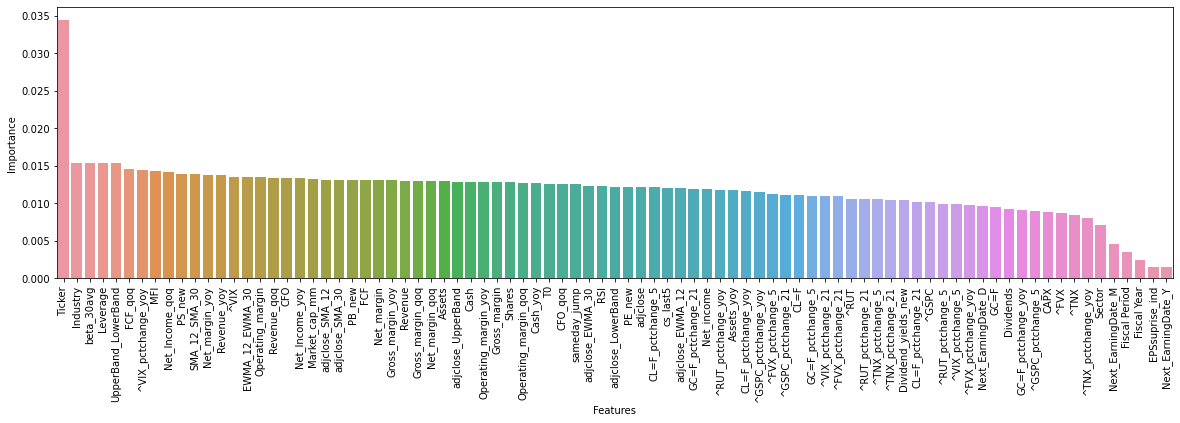

In [250]:
importances = rf_1.feature_importances_
feature_df = pd.DataFrame({'Features':X1_train.columns, 'Importance': importances})
feature_df.sort_values('Importance', ascending=False, inplace=True)

plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.barplot(x="Features", y= 'Importance', data=feature_df)

In [251]:
feature_df['Features'].values

array(['Ticker', 'Industry', 'beta_30avg', 'Leverage',
       'UpperBand_LowerBand', 'FCF_qoq', '^VIX_pctchange_yoy', 'MFI',
       'Net_Income_qoq', 'PS_new', 'SMA_12_SMA_30', 'Net_margin_yoy',
       'Revenue_yoy', '^VIX', 'EWMA_12_EWMA_30', 'Operating_margin',
       'Revenue_qoq', 'CFO', 'Net_Income_yoy', 'Market_cap_mm',
       'adjclose_SMA_12', 'adjclose_SMA_30', 'PB_new', 'FCF',
       'Net_margin', 'Gross_margin_yoy', 'Revenue', 'Gross_margin_qoq',
       'Net_margin_qoq', 'Assets', 'adjclose_UpperBand', 'Cash',
       'Operating_margin_yoy', 'Gross_margin', 'Shares',
       'Operating_margin_qoq', 'Cash_yoy', 'T0', 'CFO_qoq',
       'sameday_jump', 'adjclose_EWMA_30', 'RSI', 'adjclose_LowerBand',
       'PE_new', 'adjclose', 'CL=F_pctchange_5', 'cs_last5',
       'adjclose_EWMA_12', 'GC=F_pctchange_21', 'Net_income',
       '^RUT_pctchange_yoy', 'Assets_yoy', 'CL=F_pctchange_yoy',
       '^GSPC_pctchange_yoy', '^FVX_pctchange_5', '^GSPC_pctchange_21',
       'CL=F', 'GC=F_pct

In [252]:
feature_dict = {}

for i, feat in enumerate(list(feature_df['Features'].values)):
    feature_dict[feat] = i+1

feature_df['Rank'] = feature_df['Features'].map(lambda x: feature_dict[x])

In [253]:
feature_df = feature_df.loc[feature_df.Rank <= 15]
feature_df

,Features,Importance,Rank
0,Ticker,0.034513,1
34,Industry,0.015452,2
1,beta_30avg,0.015427,3
30,Leverage,0.015334,4
45,UpperBand_LowerBand,0.015328,5
32,FCF_qoq,0.014593,6
57,^VIX_pctchange_yoy,0.014475,7
36,MFI,0.014340,8
17,Net_Income_qoq,0.014183,9
78,PS_new,0.013943,10


<AxesSubplot:xlabel='Features', ylabel='Importance'>

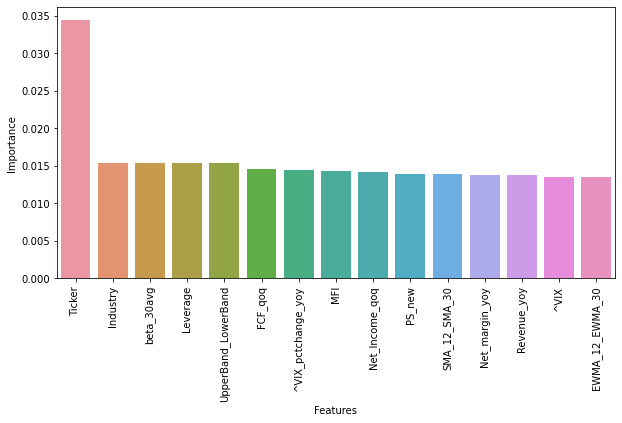

In [255]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.barplot(x="Features", y= 'Importance', data=feature_df)

## Drop Features with the least importance

In [95]:
drop_feats = list(feature_df.loc[feature_df.Importance < 0.010]['Features'])

In [96]:
features = list(feature_df.loc[feature_df.Importance >= 0.010]['Features'])

In [97]:
len(features)

67

## Train another model with features dropped

In [98]:
X2 = X1.drop(columns=drop_feats)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=1, train_size=0.7)

In [99]:
rf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2.fit(X2_train, y_train)

# sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=1, step=1)

RandomForestClassifier(random_state=42)

## Prediction Probabilities

In [203]:
r1_probs = [0 for _ in range(len(y_test))]
rf1_probs = rf_1.predict_proba(X1_test)
rf2_probs = rf_2.predict_proba(X2_test)

Probabilities for a Positive outcome is kept

In [206]:
rf1_probs = rf1_probs[:, 1]
rf2_probs = rf2_probs[:, 1]

## Computing AUC and ROC curve

In [102]:
from sklearn.metrics import roc_auc_score, roc_curve

#### Calculate AUC

**ROC** is the receiver operating characteristic
**AUC** is the area under the ROC curve

In [208]:
r_auc = roc_auc_score(y_test, r1_probs)
rf1_auc = roc_auc_score(y_test, rf1_probs)
rf2_auc = roc_auc_score(y_test, rf2_probs)

## AUC Scores

In [104]:
print('Random (chance) Prediction: AUROC = %.3f' %(r_auc))
print('Random Forest Model 1 (All Features) Prediction: AUROC = %.3f' %(rf1_auc))
print('Random Forest Model 2 (Selected Features) Prediction: Prediction: AUROC = %.3f' %(rf2_auc))

Random (chance) Prediction: AUROC = 0.500
Random Forest Model 1 (All Features) Prediction: AUROC = 0.708
Random Forest Model 2 (Selected Features) Prediction: Prediction: AUROC = 0.696


## Calculate ROC Curves

In [211]:
r1_fpr, r1_tpr, _ = roc_curve(y_test, r1_probs)
rf1_fpr, rf1_tpr, _ = roc_curve(y_test, rf1_probs)
rf2_fpr, rf2_tpr, _ = roc_curve(y_test, rf2_probs)

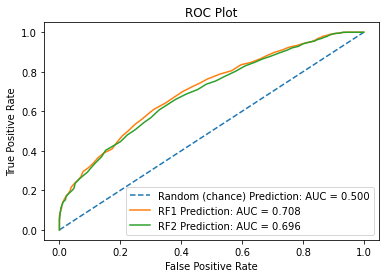

In [195]:
plt.plot(r_fpr,r_tpr, linestyle='--', label='Random (chance) Prediction: AUC = %.3f' %(r_auc))
plt.plot(rf1_fpr,rf1_tpr, label='RF1 Prediction: AUC = %.3f' %(rf1_auc))
plt.plot(rf2_fpr,rf2_tpr, label='RF2 Prediction: AUC = %.3f' %(rf2_auc))

# Title
plt.title('ROC Plot')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show legend
plt.legend()

# Show Plot
plt.show()

# Model 2 Classification

## Handling Missing Data for Model 2

In [113]:
# Assume following attributes as 0 when missing
dfmdl2['CAPX'] = dfmdl2['CAPX'].fillna(0)
dfmdl2['Dividends'] = dfmdl2['Dividends'].fillna(0)
dfmdl2['Dividend_yields_new'] = dfmdl2['Dividend_yields_new'].fillna(0)
dfmdl2['Assets_yoy'] = dfmdl2['Assets_yoy'].fillna(0)
dfmdl2['Cash_yoy'] = dfmdl2['Cash_yoy'].fillna(0)
dfmdl2['CFO_qoq'] = dfmdl2['CFO_qoq'].fillna(0)
dfmdl2['FCF_qoq'] = dfmdl2['FCF_qoq'].fillna(0)

# Assume missing gross margin = net margin  (rationale: certain industry doesn't report gross margin)
dfmdl2['Gross_margin'] = dfmdl2['Gross_margin'].fillna(dfmdl2['Operating_margin'])

# Assume missing QoQ change from average
dfmdl2["Revenue_qoq"]  = dfmdl2['Revenue_qoq'].fillna(dfmdl2.groupby('Ticker')['Revenue_qoq'].transform('mean'))
dfmdl2["Net_Income_qoq"]  = dfmdl2['Net_Income_qoq'].fillna(dfmdl2.groupby('Ticker')['Net_Income_qoq'].transform('mean'))
dfmdl2["Gross_margin_qoq"]  = dfmdl2['Gross_margin_qoq'].fillna(dfmdl2.groupby('Ticker')['Gross_margin_qoq'].transform('mean'))
dfmdl2["Operating_margin_qoq"]  = dfmdl2['Operating_margin_qoq'].fillna(dfmdl2.groupby('Ticker')['Operating_margin_qoq'].transform('mean'))
dfmdl2["Net_margin_qoq"]  = dfmdl2['Net_margin_qoq'].fillna(dfmdl2.groupby('Ticker')['Net_margin_qoq'].transform('mean'))
# if still missing: 
dfmdl2["Gross_margin_qoq"]  = dfmdl2['Gross_margin_qoq'].fillna(dfmdl2['Operating_margin_qoq'])


# Assume missing YoY change is interpolated from QoQ 
def interpolation(df,var):
    df[var+'_yoy'].fillna((1+df[var+'_qoq'])**4-1, inplace=True)
    return df

for var in ['Revenue','Net_Income','Gross_margin','Operating_margin','Net_margin']:
    interpolation(dfmdl2,var)

# Assume missing sentiment score from ticker's average, it still missing then 0
dfmdl2["cs_last5"]  = dfmdl2['cs_last5'].fillna(dfmdl2.groupby('Ticker')['cs_last5'].transform('mean'))
dfmdl2['cs_last5'] = dfmdl2['cs_last5'].fillna(0)

In [121]:
dfmdl2.shape

(8241, 88)

In [120]:
dfmdl2.dropna(inplace=True)

In [126]:
dfmdl2['target'] = np.where(dfmdl2['T1_5'] > 0.0, 1.0, 0.0)

In [163]:
list(dfmdl2.select_dtypes(include='O').columns.values)

['Ticker', 'Fiscal Period', 'Sector', 'Industry']

In [141]:
dfmdl2[['Ticker', 'Earning Date', 'Fiscal Period',
 'Sector',
 'Industry',
 'date',
 'nextday',
 'lastday']]

,Ticker,Earning Date,Fiscal Period,Sector,Industry,date,nextday,lastday
0,A,2016-08-17,Q3,Healthcare,Diagnostics & Research,2016-08-18,2016-08-19,2016-08-17
1,A,2016-11-15,Q4,Healthcare,Diagnostics & Research,2016-11-16,2016-11-17,2016-11-15
2,A,2017-02-14,Q1,Healthcare,Diagnostics & Research,2017-02-15,2017-02-16,2017-02-14
3,A,2017-05-22,Q2,Healthcare,Diagnostics & Research,2017-05-23,2017-05-24,2017-05-22
4,A,2017-08-15,Q3,Healthcare,Diagnostics & Research,2017-08-16,2017-08-17,2017-08-15
...,...,...,...,...,...,...,...,...
8268,WYNN,2020-05-06,Q1,Consumer Cyclical,Resorts & Casinos,2020-05-07,2020-05-08,2020-05-06
8269,WYNN,2020-08-04,Q2,Consumer Cyclical,Resorts & Casinos,2020-08-05,2020-08-06,2020-08-04
8270,WYNN,2020-11-05,Q3,Consumer Cyclical,Resorts & Casinos,2020-11-06,2020-11-09,2020-11-05
8271,WYNN,2021-02-04,Q4,Consumer Cyclical,Resorts & Casinos,2021-02-05,2021-02-08,2021-02-04


In [142]:
dfmdl2.drop(columns='lastday', axis=0, inplace=True)

In [154]:
def date_handler(data, columns):
    for col in columns:      
        data[col] = pd.to_datetime(data[col], format='%Y-%m-%d')
        data[col+'_Y'] = data.col.dt.year
        data[col+'_M'] = data.col.dt.month
        data[col+'_D'] = data.col.dt.day
        data.drop(columns=[col], inplace=True)
    return data

In [151]:
date_columns = ['Earning Date','date','nextday']

In [152]:
dfmdl2 = date_handler(dfmdl2, date_columns)

/var/folders/g0/x29rhtxs77n94c0nv9tn68km0000gn/T/ipykernel_6536/3373166234.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.col = pd.to_datetime(data[col], format='%Y-%m-%d')


In [160]:
dfmdl2.head()

,Ticker,beta_30avg,adjclose,Fiscal Year,Fiscal Period,Revenue,Net_income,Shares,Cash,Assets,...,T1,T1_5,target,Earning Date_Y,Earning Date_M,Earning Date_D,date_M,date_D,nextday_M,nextday_D
0,A,1.562381,46.201164,2016,Q3,1.044000e+09,124000000,325000000.0,2.199000e+09,7734000000,...,44.569862,-0.000428,0.0,2016,8,17,8,18,8,19
1,A,1.727714,43.418201,2016,Q4,1.111000e+09,126000000,324000000.0,2.289000e+09,7794000000,...,44.164143,-0.037246,0.0,2016,11,15,11,16,11,17
2,A,2.014411,48.329895,2017,Q1,1.067000e+09,168000000,322000000.0,2.241000e+09,7872000000,...,49.509624,-0.005424,0.0,2017,2,14,2,15,2,16
3,A,1.260812,53.920761,2017,Q2,1.102000e+09,164000000,321000000.0,2.389000e+09,8016000000,...,56.401424,0.029151,1.0,2017,5,22,5,23,5,24
4,A,1.045623,57.220871,2017,Q3,1.114000e+09,175000000,321000000.0,2.563000e+09,8261000000,...,59.880497,0.013196,1.0,2017,8,15,8,16,8,17


In [162]:
dfmdl2[['Fiscal Year', 'Earning Date_Y', 'Earning Date_M', 'date_M', 'nextday_M']].describe()

,Fiscal Year,Earning Date_Y,Earning Date_M,date_M,nextday_M
count,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000
mean,2018.334547,2018.531853,5.931683,5.999393,6.093314
std,1.485801,1.491639,3.250477,3.246750,3.245109
min,2016.000000,2016.000000,1.000000,1.000000,1.000000
25%,2017.000000,2017.000000,4.000000,4.000000,4.000000
50%,2018.000000,2019.000000,5.000000,5.000000,5.000000
75%,2020.000000,2020.000000,8.000000,8.000000,8.000000
max,2021.000000,2021.000000,12.000000,12.000000,12.000000


In [159]:
dfmdl2.drop(columns=['date_Y', 'nextday_Y'], axis=0, inplace=True)

In [164]:
fp_unq = len(dfmdl2['Fiscal Period'].unique())
tick_unq = len(dfmdl2['Ticker'].unique())
sec_unq = len(dfmdl2['Sector'].unique())
ind_unq = len(dfmdl2['Industry'].unique())

print(f'Fiscal Period={fp_unq}')
print(f'Ticker={tick_unq}')        
print(f'Sector={sec_unq}')
print(f'Industry={ind_unq}')

Fiscal Period=4
Ticker=408
Sector=11
Industry=105


In [166]:
# Apply label encoding on the Fiscal Period column
dfmdl2 = label_encoding(dfmdl2, 'Fiscal Period')

# Apply target encoding on Ticker, Sector, and Industry columns
dfmdl2 = target_encoding(dfmdl2, ['Ticker','Sector','Industry'], 'T1_5')

In [167]:
fp_unq = len(dfmdl2['Fiscal Period'].unique())
tick_unq = len(dfmdl2['Ticker'].unique())
sec_unq = len(dfmdl2['Sector'].unique())
ind_unq = len(dfmdl2['Industry'].unique())

print(f'Fiscal Period={fp_unq}')
print(f'Ticker={tick_unq}')        
print(f'Sector={sec_unq}')
print(f'Industry={ind_unq}')

Fiscal Period=4
Ticker=408
Sector=11
Industry=105


In [168]:
dfmdl2.EPSsuprise_ind = dfmdl2.EPSsuprise_ind.astype(int)

In [169]:
dfmdl2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [170]:
dfmdl2.dropna(inplace=True)

In [171]:
dfmdl2.shape

(8221, 92)

In [179]:
X3 = dfmdl2.drop(columns=['T1_5', 'target'], axis=0)
y2 = dfmdl2['target']

X3_train, X3_test, y2_train, y2_test = train_test_split(X3, y2, random_state=1, train_size=0.7)

In [180]:
rf_3 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_3.fit(X3_train, y2_train)

RandomForestClassifier(random_state=42)

<AxesSubplot:xlabel='Features', ylabel='Importance'>

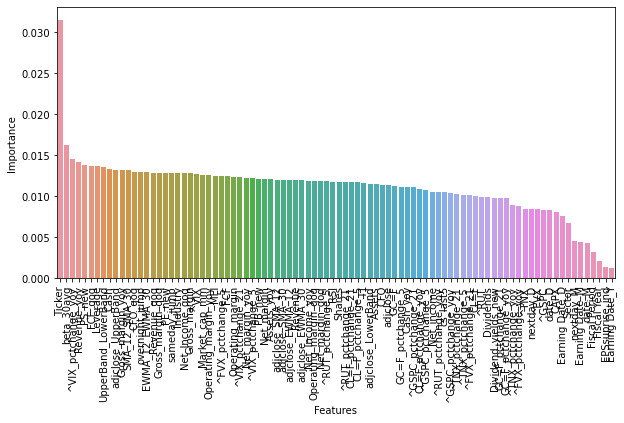

In [230]:
importances = rf_3.feature_importances_
feature2_df = pd.DataFrame({'Features':X3_train.columns, 'Importance': importances})
feature2_df.sort_values('Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.barplot(x="Features", y= 'Importance', data=feature2_df)

In [183]:
drop_feats2 = list(feature2_df.loc[feature2_df.Importance < 0.010]['Features'])
features2 = list(feature2_df.loc[feature2_df.Importance >= 0.010]['Features'])

In [185]:
X4 = X3.drop(columns=drop_feats2)
X4_train, X4_test, y2_train, y2_test = train_test_split(X4, y2, random_state=1, train_size=0.7)

In [186]:
rf_4 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_4.fit(X4_train, y_train)


RandomForestClassifier(random_state=42)

In [212]:
r2_probs = [0 for _ in range(len(y2_test))]
rf3_probs = rf_3.predict_proba(X3_test)[:, 1]
rf4_probs = rf_4.predict_proba(X4_test)[:, 1]

In [188]:
# rf3_probs = rf3_probs
# rf4_probs = rf4_probs

In [213]:
rf3_auc = roc_auc_score(y2_test, rf3_probs)
rf4_auc = roc_auc_score(y2_test, rf4_probs)

In [190]:
print('Random Forest Model 3 (All Features) Prediction: AUROC = %.3f' %(rf3_auc))
print('Random Forest Model 4 (Selected Features) Prediction: Prediction: AUROC = %.3f' %(rf4_auc))

Random Forest Model 3 (All Features) Prediction: AUROC = 0.734
Random Forest Model 4 (Selected Features) Prediction: Prediction: AUROC = 0.722


In [214]:
r2_fpr, r2_tpr, _ = roc_curve(y2_test, r2_probs)
rf3_fpr, rf3_tpr, _ = roc_curve(y2_test, rf3_probs)
rf4_fpr, rf4_tpr, _ = roc_curve(y2_test, rf4_probs)

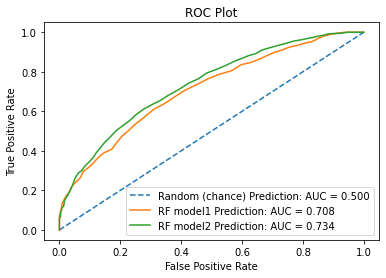

In [197]:
plt.plot(r_fpr,r_tpr, linestyle='--', label='Random (chance) Prediction: AUC = %.3f' %(r_auc))
plt.plot(rf1_fpr,rf1_tpr, label='RF model1 Prediction: AUC = %.3f' %(rf1_auc))
# plt.plot(rf2_fpr,rf2_tpr, label='RF2 model1 Prediction: AUC = %.3f' %(rf2_auc))
plt.plot(rf3_fpr,rf3_tpr, label='RF model2 Prediction: AUC = %.3f' %(rf3_auc))
# plt.plot(rf4_fpr,rf4_tpr, label='RF4 model2 Prediction: AUC = %.3f' %(rf4_auc))

# Title
plt.title('ROC Plot')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show legend
plt.legend()

# Show Plot
plt.show()

In [198]:
import plotly.express as px

In [218]:
df1 = pd.DataFrame({'Model1_FPR':rf1_fpr, 'Model1_TPR':rf1_tpr})
df2 =  pd.DataFrame({'Model2_FPR':rf3_fpr, 'Model2_TPR':rf3_tpr})

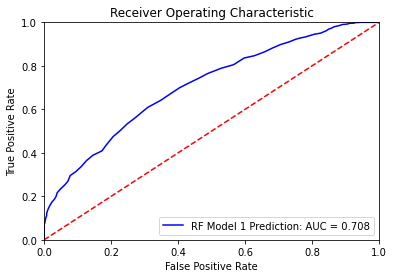

In [229]:
plt.title('Receiver Operating Characteristic')
plt.plot(rf1_fpr, rf1_tpr, 'b', label = 'RF Model 1 Prediction: AUC = %.3f' % rf1_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

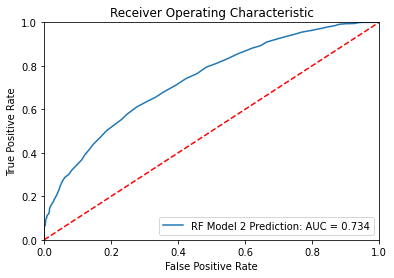

In [228]:
plt.title('Receiver Operating Characteristic')
plt.plot(rf3_fpr,rf3_tpr, label='RF Model 2 Prediction: AUC = %.3f' %(rf3_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
